In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re

import cptac
import cptac.utils as u

import plot_utils as pu

In [2]:
# Returns a dataframe with proteomics and mutation type

# all_prot: list of trans genes

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN'):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot)
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV')
        # Get only tumor samples
        p = cancer_object.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


In [3]:
en = cptac.Endometrial()
g = cptac.Gbm()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


In [4]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
sig_df = pd.read_csv(root+R'\sig_pval_heatmap.csv')

In [6]:
prot_list = list(sig_df.Proteomics) # list of genes with a sig pval in >= 1 cancer
prot_enr = gp.enrichr(gene_list = prot_list, description='Tumor_partition', gene_sets='KEGG_2016', 
                       outdir='/Enrichr')
prot_enr.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Spliceosome Homo sapiens hsa03040,88/134,2.936551e-44,8.604095e-42,0,0,4.860965,487.246193,RBM25;EIF4A3;DDX42;HNRNPU;PRPF19;USP39;EFTUD2;...,KEGG_2016
1,RNA transport Homo sapiens hsa03013,77/172,1.113872e-23,1.631823e-21,0,0,3.313652,175.131871,CYFIP2;NUP107;NUP188;RPP30;EIF4A3;PHAX;PNN;XPO...,KEGG_2016
2,DNA replication Homo sapiens hsa03030,23/36,3.613010e-12,3.528707e-10,0,0,4.729007,124.592696,RFC5;FEN1;RFC3;PCNA;RFC4;MCM7;RFC1;RFC2;PRIM1;...,KEGG_2016
3,mRNA surveillance pathway Homo sapiens hsa03015,38/91,2.801846e-11,2.052353e-09,0,0,3.090914,75.103503,SMG1;RBM8A;RNMT;CSTF3;EIF4A3;MSI1;PPP2R2A;MSI2...,KEGG_2016
4,Mismatch repair Homo sapiens hsa03430,15/23,1.473843e-08,8.636717e-07,0,0,4.827342,87.050531,RFC5;RFC3;PCNA;RFC4;RFC1;RFC2;RPA1;MLH1;POLD3;...,KEGG_2016


In [7]:
dna_rep = prot_enr.res2d.Genes[2]
dna_genes = dna_rep.split(';')

In [66]:
def binary_val_plot(df1, df1_name, df2, df2_name, val = 'p-value', cat_df=None, save_file_name=None):
    # Step 1: Combine Dataframes
    combined = df1.merge(df2, on=df1.columns[0]) # merge 2 pval df
    combined = combined.replace(regex=True,to_replace='_proteomics', value='') # only gene names
    #if val == 'p-value':
    #combined_df = combined.rename(columns={combined.columns[1]: df1_name+' p-values',
    #                                          combined.columns[2]: df2_name+' p-values'}) # Rename for x and y-axis
    combined_df = combined.rename(columns={combined.columns[1]: df1_name,
                                              combined.columns[2]: df2_name}) # Rename for x and y-axis
        
    if cat_df is not None:
        combined_df = combined_df.merge(cat_df, left_on= combined_df.columns[0], right_on= cat_df.columns[0]) # merge pathways

    else: # Plots one plot if no cat_df provided
        if val == 'p-value':
            plt.figure(figsize=(6, 6))
            all_pvals = sns.scatterplot(x=combined_df.columns[1], y=combined_df.columns[2], data=combined_df)
            all_pvals.set_title("Comprehensive "+df1_name+" and "+df2_name+ " P-Values")
            all_pvals.set_xscale('log')
            all_pvals.set_yscale('log')
            plt.xlim(1e-5, 1e0) # 0.00005 to 1
            plt.ylim(1e-5, 1e0)
        elif val == 'correlation':
            plt.figure(figsize=(6, 6))
            all_pvals = sns.scatterplot(x=combined_df.columns[1], y=combined_df.columns[2], data=combined_df)
            all_pvals.set_title("Comprehensive "+df1_name+" and "+df2_name)
            plt.xlim(-1.5, 1.5) # 0.00005 to 1
            plt.ylim(-1.5, 1.5)
        if save_file_name is not None:
            plt.savefig(save_file_name+'.png')
        plt.show()
        plt.clf()
        plt.close()
        return 0


In [35]:
root = R'~\Github\WhenMutationsDontMatter\PTEN\Step_3_trans_effect\csv'
en_df = pd.read_csv(root+R'\endo_pval_medians.csv')
g_df = pd.read_csv(root+R'\gbm_pval_medians.csv')

Create color col.

In [10]:
gene = 'PTEN'
g_prot = g.get_proteomics()
g_prot_list = list(g_prot.columns)
total_tests_gbm = len(g_prot_list)
gbm_bonferroni = 0.05/total_tests_gbm
gbm_bonferroni

4.487927475092003e-06

In [11]:
g_del_wt = all_prot_format_df(g, g_prot_list)
g_del_wt = g_del_wt.dropna(axis='columns', how='all')
g_del_wt.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 11)


Name,A1BG_proteomics,A2M_proteomics,AAAS_proteomics,AACS_proteomics,AADAT_proteomics,AAED1_proteomics,AAGAB_proteomics,AAK1_proteomics,AAMDC_proteomics,AAMP_proteomics,...,ZSWIM8_proteomics,ZW10_proteomics,ZWILCH_proteomics,ZWINT_proteomics,ZXDC_proteomics,ZYG11B_proteomics,ZYX_proteomics,ZZEF1_proteomics,ZZZ3_proteomics,Mutation
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00104,0.077630,0.487228,-0.254208,-0.144373,0.551881,-0.025276,-0.467451,-0.089511,-0.078806,0.329603,...,-0.047437,-0.105908,-0.347076,NaN,0.459635,0.079452,-0.784983,-0.488441,0.167990,Deletion
C3L-00365,-0.145975,0.798796,0.184242,-0.470603,NaN,0.390211,0.245466,-0.609998,0.118625,-0.086927,...,0.161975,-0.213093,0.235571,NaN,0.107421,0.048724,0.138403,-0.290141,0.405037,Deletion
C3L-00674,0.821991,1.096470,-0.094421,-0.106304,0.084578,0.176402,-0.248151,0.014061,-0.699773,-0.638462,...,-0.065534,-0.306717,0.879991,NaN,0.883564,-0.172222,0.011876,-0.131889,-0.503581,Deletion
C3L-00677,-0.064567,0.129385,0.047751,-0.118187,0.237434,NaN,0.303847,0.322163,-0.555479,-0.363414,...,-0.254535,0.463653,0.580230,0.503044,-0.604986,0.178077,-0.720059,-0.150197,-0.268715,Deletion
C3L-01040,-0.763691,-1.031834,-0.217194,-0.695701,0.184173,-0.474816,-0.051789,0.344842,-0.642746,0.068863,...,-0.092502,0.010639,-0.465079,NaN,-0.500083,0.112651,1.004660,-0.230304,-0.102416,Deletion


In [12]:
cols = list(g_del_wt.columns[:-1])

# Get only sig genes
g_sig = u.wrap_ttest(g_del_wt, 'Mutation', cols, correction_method = 'fdr_bh')
# Create list of sig genes
if g_sig is not None:
    g_sig_list = list(g_sig.Comparison)
else: 
    g_sig_list = None
print('significant pvals: \n',g_sig)

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\brittany henderson\Anaconda3\e

significant pvals: 
               Comparison       P_Value
0       ARMH3_proteomics  5.396032e-11
1        CUTC_proteomics  1.593480e-10
2     PIP4K2A_proteomics  1.009419e-09
3        CUL2_proteomics  1.122076e-09
4        GDI2_proteomics  1.302273e-09
...                  ...           ...
1882  GOLGA7B_proteomics  8.446816e-03
1883     TEX2_proteomics  8.452685e-03
1884     MAFF_proteomics  8.463737e-03
1885   LRPAP1_proteomics  8.466030e-03
1886  PPP2R2B_proteomics  8.466960e-03

[1887 rows x 2 columns]


Create df with pvals from both cancers for all genes in a pathway

In [30]:
#split by end of line char?
all_dna_rep = 'DNA2 FEN1 LIG1 MCM2 MCM3 MCM4 MCM5 MCM6 MCM7 PCNA POLA1 POLA2 POLD1 POLD2 POLD3 POLD4 POLE POLE2 POLE3 POLE4 PRIM1 PRIM2 RFC1 RFC2 RFC3 RFC4 RFC5 RNASEH1 RNASEH2A RNASEH2B RNASEH2C RPA1 RPA2 RPA3 RPA4 SSBP1'
all_dna_genes = all_dna_rep.split(' ')

In [33]:
# Cancer 1
g_pval = g_df.drop(columns='Gbm_Median')
g_pval = g_pval.replace(regex=True,to_replace='_proteomics', value='')
gb = g_pval.Proteomics.isin(all_dna_genes)
gbm_df = g_pval[gb]

In [37]:
# cancer 2
e_pval = en_df.drop(columns='En_Median')
e_pval = e_pval.replace(regex=True,to_replace='_proteomics', value='')
eb = e_pval.Proteomics.isin(all_dna_genes)
endo_df = e_pval[eb] 

,Proteomics,En_P_Value
261,RFC2,0.000651
439,RFC4,0.002179
623,RFC5,0.004491
839,MCM2,0.007643
902,RNASEH1,0.008776
920,MCM6,0.009135
1070,PCNA,0.012305
1082,MCM5,0.012583
1122,MCM7,0.013850
1153,MCM3,0.015138


In [43]:
# merge

both = gbm_df.merge(endo_df, on ='Proteomics', how='outer')

In [61]:
# Create color col

def Color(row):
    sig1 = False
    sig2 = False

    for item in row:
        print(row,'\n')
        if pd.isnull(item):
            continue
        if item < 0.05:
            sig1 = True
        if item < 0.05:
            sig2 = True
           
    if sig1 & sig2:
        return True
    return False

In [62]:
bdf = both.drop(columns='Proteomics')
bdf

,Gbm_P_Value,En_P_Value
0,0.000014,0.009135
1,0.000014,0.015520
2,0.000019,0.012305
3,0.000020,0.325164
4,0.000036,0.882756
5,0.000037,0.004491
6,0.000041,0.012583
7,0.000041,0.007643
8,0.000053,0.013850
9,0.000083,0.015138


In [63]:
b = bdf.apply(Color, axis = 1)

Gbm_P_Value    0.000014
En_P_Value     0.009135
Name: 0, dtype: float64 

Gbm_P_Value    0.000014
En_P_Value     0.009135
Name: 0, dtype: float64 

Gbm_P_Value    0.000014
En_P_Value     0.015520
Name: 1, dtype: float64 

Gbm_P_Value    0.000014
En_P_Value     0.015520
Name: 1, dtype: float64 

Gbm_P_Value    0.000019
En_P_Value     0.012305
Name: 2, dtype: float64 

Gbm_P_Value    0.000019
En_P_Value     0.012305
Name: 2, dtype: float64 

Gbm_P_Value    0.000020
En_P_Value     0.325164
Name: 3, dtype: float64 

Gbm_P_Value    0.000020
En_P_Value     0.325164
Name: 3, dtype: float64 

Gbm_P_Value    0.000036
En_P_Value     0.882756
Name: 4, dtype: float64 

Gbm_P_Value    0.000036
En_P_Value     0.882756
Name: 4, dtype: float64 

Gbm_P_Value    0.000037
En_P_Value     0.004491
Name: 5, dtype: float64 

Gbm_P_Value    0.000037
En_P_Value     0.004491
Name: 5, dtype: float64 

Gbm_P_Value    0.000041
En_P_Value     0.012583
Name: 6, dtype: float64 

Gbm_P_Value    0.000041
En_P_Value    

In [53]:
b

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28    False
29     True
30     True
31    False
32    False
33    False
dtype: bool

In [96]:
gbm_df['c'] = 'grey'
cutoff=.05
gbm_df['c'] = np.where(gbm_df['Gbm_P_Value'] < 0.05, 'yellow', 'grey')

#trunc_mutations['Mutation'] = np.where(
 #               trunc_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
#ec = en_df.drop(columns='En_P_Value')
ec = en_df.replace(regex=True,to_replace='_proteomics', value='')
eb = ec.Proteomics.isin(all_dna_genes)
endo_df = ec[eb]
endo_df 

,Proteomics,En_P_Value,En_Median
261,RFC2,0.000651,-0.37200
439,RFC4,0.002179,-0.32870
623,RFC5,0.004491,-0.46590
839,MCM2,0.007643,-0.61100
902,RNASEH1,0.008776,-0.19595
920,MCM6,0.009135,-0.62300
1070,PCNA,0.012305,-0.23500
1082,MCM5,0.012583,-0.61810
1122,MCM7,0.013850,-0.56500
1153,MCM3,0.015138,-0.50400


In [118]:
#endo_df['co'] = np.where(endo_df['En_P_Value'] < 0.05, 'blue', 'grey')

#endo_df['c'] = 'l'
endo_df['En_P_Values'] = endo_df['c'].apply(lambda x: 'y' if x < 0.05 else 'g')

KeyError: 'c'

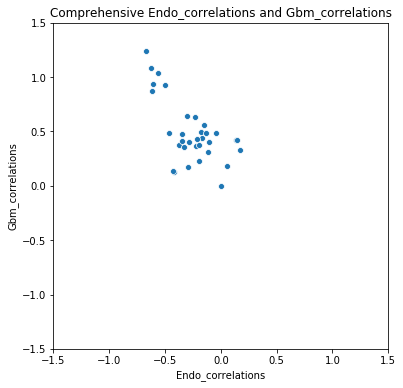

0

In [67]:
binary_val_plot(endo_df, 'Endo_correlations', gbm_df, 'Gbm_correlations', val = 'correlation')